# Hyunwoo Moon's Amazing Code

## Import

In [1]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.models as models

from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2

import torchvision.models as models

import math
import random

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Utils

In [2]:
# RLE 디코딩 함수
def rle_decode(mask_rle, shape):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape)

# RLE 인코딩 함수
def rle_encode(mask):
    pixels = mask.flatten()

    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]

    
    return ' '.join(str(x) for x in runs)


## Custom Dataset

In [3]:
class SatelliteDataset(Dataset):
    def __init__(self, csv_file, transform=None, infer=False, crop_size=224):
        self.data = pd.read_csv(csv_file)
        self.transform = transform
        self.infer = infer
        self.crop_size = crop_size

    def __len__(self):
        return len(self.data)

    def crop_and_augment_image(self, image, mask):
        # 임의로 이미지를 crop
        h, w = image.shape[:2]
        top = np.random.randint(0, h - self.crop_size)
        left = np.random.randint(0, w - self.crop_size)
        image = image[top: top + self.crop_size, left: left + self.crop_size]
        mask = mask[top: top + self.crop_size, left: left + self.crop_size]

        # 이미지 증강
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask

    def __getitem__(self, idx):
        img_path = self.data.iloc[idx, 1]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.infer:
            if self.transform:
                image = self.transform(image=image)['image']
            return image

        mask_rle = self.data.iloc[idx, 2]
        mask = rle_decode(mask_rle, (image.shape[0], image.shape[1]))

        # 이미지 crop 및 증강
        image, mask = self.crop_and_augment_image(image, mask)

        return image, mask
    
    

## Data Loader

In [4]:
transform_train = A.Compose(
    [        
        # 랜덤 크롭 추가
        #A.RandomCrop(224, 224),
        
        # 랜덤 회전 추가 (±45도 범위에서 랜덤하게 회전)
        #A.Rotate(limit=45, p=0.5),

        # 랜덤 상하 대칭 추가
        A.VerticalFlip(p=0.5),
        # 랜덤 좌우 대칭 추가
        A.HorizontalFlip(p=0.5),

        # 이미지 크기 조정
        A.Resize(224, 224),

        # 명암 대비 조정과 밝기 조절
        #A.RandomBrightnessContrast(brightness_limit=(-0.2, 0.2), contrast_limit=(-0.2, 0.2), always_apply=True),

        # 색감 조정
        #A.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1, always_apply=True),
        
        A.Normalize(),

        # 이미지를 텐서로 변환
        ToTensorV2()
    ]
)

transform_test = A.Compose(
    [
        # 이미지 크기 조정
        A.Resize(224, 224),
        
        A.Normalize(),

        # 이미지를 텐서로 변환
        ToTensorV2()
    ]
)

dataset = SatelliteDataset(csv_file='./train.csv', transform=transform_train, crop_size=224)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=4)

## Define Model

In [5]:
# U-Net의 기본 구성 요소인 Double Convolution Block을 정의합니다.
def double_conv(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, 3, padding=1),
        nn.ReLU(inplace=True)
    )

# 간단한 U-Net 모델 정의
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.dconv_down1 = double_conv(3, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        

        self.dconv_up3 = double_conv(256 + 512, 256)
        self.dconv_up2 = double_conv(128 + 256, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)

        self.conv_last = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   

        x = self.dconv_down4(x)

        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)

        x = self.dconv_up3(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)       

        x = self.dconv_up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)   

        x = self.dconv_up1(x)

        out = self.conv_last(x)

        return out

# 깊은 U-Net 모델 정의
class DeepUNet(nn.Module):
    def __init__(self):
        super(DeepUNet, self).__init__()
        self.dconv_down1 = double_conv(3, 64)
        self.dconv_down2 = double_conv(64, 128)
        self.dconv_down3 = double_conv(128, 256)
        self.dconv_down4 = double_conv(256, 512)
        self.dconv_down5 = double_conv(512, 1024)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)        

        self.dconv_up4 = double_conv(1024 + 512, 512)
        self.dconv_up3 = double_conv(512 + 256, 256)
        self.dconv_up2 = double_conv(256 + 128, 128)
        self.dconv_up1 = double_conv(128 + 64, 64)

        self.conv_last = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)
        
        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)   

        conv4 = self.dconv_down4(x)
        x = self.maxpool(conv4)

        x = self.dconv_down5(x)

        x = self.upsample(x)        
        x = torch.cat([x, conv4], dim=1)

        x = self.dconv_up4(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv3], dim=1)

        x = self.dconv_up3(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv2], dim=1)       

        x = self.dconv_up2(x)
        x = self.upsample(x)        
        x = torch.cat([x, conv1], dim=1)   

        x = self.dconv_up1(x)

        out = self.conv_last(x)

        return out


## Select Model

In [6]:
# UNet / DeepUNet
select_model = 'DeepUNet'    # 사용할 모델 선택

## Select Mode

In [7]:
# Nothing : -1 / Training : 0 / Inference : 1 / Traing & Inference : 2
mode = 2

## Model Train

In [8]:
if mode in [0, 2]:
    # 모델 초기화
    if select_model == 'UNet':
        model = UNet().to(device)
    elif select_model == 'DeepUNet':
        model = DeepUNet().to(device)
        
    # 가중치 설정
    building_weight = 10.0
    non_building_weight = 1.0
    pos_weight = torch.tensor([building_weight/non_building_weight]).to(device)

    # loss function과 optimizer 정의
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # training loop
    for epoch in range(50):  # 50 에폭 동안 학습합니다.
        model.train()
        epoch_loss = 0
        for images, masks in tqdm(dataloader):
            images = images.float().to(device)
            masks = masks.float().to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks.unsqueeze(1))
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        print(f'Epoch {epoch+1}, Loss: {epoch_loss/len(dataloader)}')
    
        torchrewgct_model + ').pt')
 5.70it/s]
  0%|          | 0/1785 [00:00<?, ?it

  0%|          | 0/1785 [00:00<?, ?it/s]

Epoch 1, Loss: 0.7600751918028382


  0%|          | 0/1785 [00:00<?, ?it/s]

Epoch 2, Loss: 0.7060095870194315


  0%|          | 0/1785 [00:00<?, ?it/s]

Epoch 3, Loss: 0.6725985360370964


  0%|          | 0/1785 [00:00<?, ?it/s]

Epoch 4, Loss: 0.6932304730685819


  0%|          | 0/1785 [00:00<?, ?it/s]

Epoch 5, Loss: 0.6517974675953889


  0%|          | 0/1785 [00:00<?, ?it/s]

Epoch 6, Loss: 0.6371906941678344


  0%|          | 0/1785 [00:00<?, ?it/s]

Epoch 7, Loss: 0.6316443416209114


  0%|          | 0/1785 [00:00<?, ?it/s]

Epoch 8, Loss: 0.615554999340983


  0%|          | 0/1785 [00:00<?, ?it/s]

Epoch 9, Loss: 0.6139687089379929


  0%|          | 0/1785 [00:00<?, ?it/s]

Epoch 10, Loss: 0.6052726247856597


100%|██████████| 1785/1785 [03:09<00:00,  9.40it/s]


Epoch 11, Loss: 0.5949310792135257


  0%|          | 0/1785 [00:00<?, ?it/s]

Epoch 12, Loss: 0.5996416918829042


100%|██████████| 1785/1785 [03:11<00:00,  9.33it/s]


Epoch 13, Loss: 0.6024043793354382


100%|██████████| 1785/1785 [03:10<00:00,  9.36it/s]


Epoch 14, Loss: 0.5882375079001031


  0%|          | 0/1785 [00:00<?, ?it/s]

Epoch 15, Loss: 0.589955938864155


  0%|          | 0/1785 [00:00<?, ?it/s]

Epoch 16, Loss: 0.5815887896244933


  0%|          | 0/1785 [00:00<?, ?it/s]

Epoch 17, Loss: 0.5768411552350895


  0%|          | 0/1785 [00:00<?, ?it/s]

Epoch 18, Loss: 0.5835924630781182


  0%|          | 0/1785 [00:00<?, ?it/s]

Epoch 19, Loss: 0.5866049296861771


  0%|          | 0/1785 [00:00<?, ?it/s]

Epoch 20, Loss: 0.5701150907980962


  0%|          | 0/1785 [00:00<?, ?it/s]

Epoch 21, Loss: 0.5757648970065664


  0%|          | 0/1785 [00:00<?, ?it/s]

Epoch 22, Loss: 0.5806249077914476


  0%|          | 0/1785 [00:00<?, ?it/s]

Epoch 23, Loss: 0.5707896548764212


  0%|          | 0/1785 [00:00<?, ?it/s]

Epoch 24, Loss: 0.5739845694634927


  0%|          | 0/1785 [00:00<?, ?it/s]

Epoch 25, Loss: 0.5702410582400838


  0%|          | 0/1785 [00:00<?, ?it/s]

Epoch 26, Loss: 0.5640057722810937


  0%|          | 0/1785 [00:00<?, ?it/s]

Epoch 27, Loss: 0.5641813950712273


  0%|          | 0/1785 [00:00<?, ?it/s]

Epoch 28, Loss: 0.5772379013587113


  0%|          | 0/1785 [00:00<?, ?it/s]

Epoch 29, Loss: 0.5621660337039903


  0%|          | 0/1785 [00:00<?, ?it/s]

Epoch 30, Loss: 0.5689865216070197


  0%|          | 0/1785 [00:00<?, ?it/s]

Epoch 31, Loss: 0.5628598032503569


  0%|          | 0/1785 [00:00<?, ?it/s]

Epoch 32, Loss: 0.5639767826688724


  0%|          | 0/1785 [00:00<?, ?it/s]

Epoch 33, Loss: 0.5707225572703933


  0%|          | 0/1785 [00:00<?, ?it/s]

Epoch 34, Loss: 0.5633467048156161


  0%|          | 0/1785 [00:00<?, ?it/s]

Epoch 35, Loss: 0.562075429687313


  0%|          | 0/1785 [00:00<?, ?it/s]

Epoch 36, Loss: 0.5680217784492909


  0%|          | 0/1785 [00:00<?, ?it/s]

Epoch 37, Loss: 0.5502041271420754


  0%|          | 0/1785 [00:00<?, ?it/s]

Epoch 38, Loss: 0.5543733957434903


  0%|          | 0/1785 [00:00<?, ?it/s]

Epoch 39, Loss: 0.5630623967999837


  0%|          | 0/1785 [00:00<?, ?it/s]

Epoch 40, Loss: 0.5520135908442385


  0%|          | 0/1785 [00:00<?, ?it/s]

Epoch 41, Loss: 0.552723440550873


  0%|          | 0/1785 [00:00<?, ?it/s]

Epoch 42, Loss: 0.5552642309135583


  0%|          | 0/1785 [00:00<?, ?it/s]

Epoch 43, Loss: 0.5601212164016665


  0%|          | 0/1785 [00:00<?, ?it/s]

Epoch 44, Loss: 0.5609655354224167


  0%|          | 0/1785 [00:00<?, ?it/s]

Epoch 45, Loss: 0.5570527955847961


  0%|          | 0/1785 [00:00<?, ?it/s]

Epoch 46, Loss: 0.5503392682168163


100%|██████████| 1785/1785 [03:40<00:00,  8.11it/s]


Epoch 47, Loss: 0.5605848524583822


100%|██████████| 1785/1785 [03:40<00:00,  8.08it/s]


Epoch 48, Loss: 0.5597152014865595


  0%|          | 0/1785 [00:00<?, ?it/s]

Epoch 49, Loss: 0.5546176901363692


100%|██████████| 1785/1785 [03:41<00:00,  8.05it/s]


Epoch 50, Loss: 0.5554654853642822


## Inference

In [9]:
test_dataset = SatelliteDataset(csv_file='./test.csv', transform=transform_test, infer=True)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=4)

In [10]:
# 모델 기반 후처리 함수
post_process_limit = 5    # 노이즈 취급 범위

def post_process_mask(masks):
    processed_masks = []
    kernel = np.ones((post_process_limit, post_process_limit), np.uint8)
    
    for mask in masks:
        # 작은 객체를 제거하거나 작은 구멍을 메우는 데 사용
        mask_processed = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
        # 작은 구멍을 메우거나 끊어진 객체를 연결하는 데 사용
        # mask_processed = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
        processed_masks.append(mask_processed)

    return processed_masks

if mode in [1,2]:
    model = torch.load('model(' + select_model + ').pt')
    print('Inference by model(' + select_model + ').pt')

    value_Threshold = 0.5    # 시작 임계값  
    end_Threshold = 0.9    # 끝 임계값
    
    while value_Threshold <= end_Threshold:
            
        threshold = value_Threshold   # 임계값 / Original Threshold = 0.35
        
        print('threshold : ' + str(threshold))
        
        value_Threshold += 0.1000    # 임계값 증가폭
        value_Threshold = math.floor(value_Threshold * 1000) / 1000

        with torch.no_grad():
            model.eval()
            result = []
            for images in tqdm(test_dataloader):
                images = images.float().to(device)

                outputs = model(images)
                masks = torch.sigmoid(outputs).cpu().numpy()
                masks = np.squeeze(masks, axis=1)
                masks = (masks > threshold).astype(np.uint8)

                # 모델 기반 후처리를 수행하여 작은 노이즈 제거
                processed_masks = post_process_mask(masks)
                
                #for i in range(len(images)):
                for processed_mask in processed_masks:
                    #mask_rle = rle_encode(masks[i])
                    mask_rle = rle_encode(processed_mask)
                    if mask_rle == '': # 예측된 건물 픽셀이 아예 없는 경우 -1
                        result.append(-1)
                    else:
                        result.append(mask_rle)
        submit = pd.read_csv('./sample_submission.csv')
        submit['mask_rle'] = result
    
        temp = './submit(' + select_model + ' ' + str(threshold) + ' ' + str(post_process_limit) + ').csv'
        submit.to_csv(temp, index=False)
        print(temp + ' is created!!\n\n')

  0%|          | 0/15160 [00:00<?, ?it/s]

Inference by model(DeepUNet).pt
threshold : 0.5


  0%|          | 0/15160 [00:00<?, ?it/s]

./submit(DeepUNet 0.5 5).csv is created!!


threshold : 0.6


  0%|          | 0/15160 [00:00<?, ?it/s]

./submit(DeepUNet 0.6 5).csv is created!!


threshold : 0.7


  0%|          | 0/15160 [00:00<?, ?it/s]

./submit(DeepUNet 0.7 5).csv is created!!


threshold : 0.799


  0%|          | 0/15160 [00:00<?, ?it/s]

./submit(DeepUNet 0.799 5).csv is created!!


threshold : 0.899


100%|██████████| 15160/15160 [10:20<00:00, 24.44it/s]


./submit(DeepUNet 0.899 5).csv is created!!




## Submission

In [11]:
#if mode in [1,2]:
#    submit = pd.read_csv('./sample_submission.csv')
#    submit['mask_rle'] = result
#    
#    temp = './submit(' + select_model + ' ' + str(threshold) + ').csv'
#    submit.to_csv(temp, index=False)

In [12]:
#temp = './submit(' + select_model + ' ' + str(threshold) + ').csv'
#submit.to_csv(temp, index=False)

## Visualization

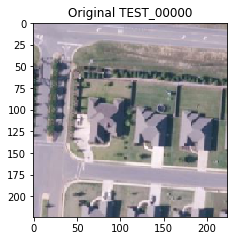

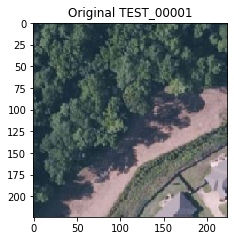

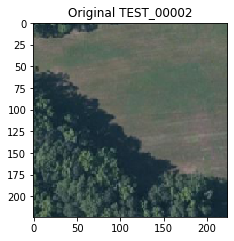

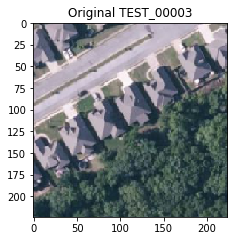

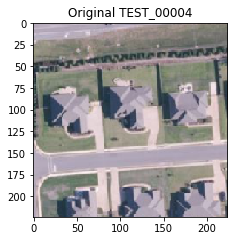

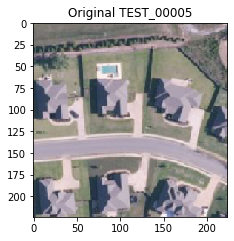

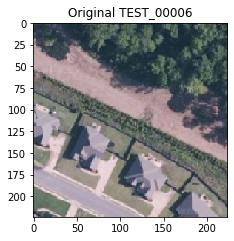

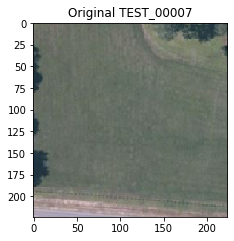

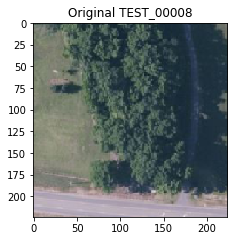

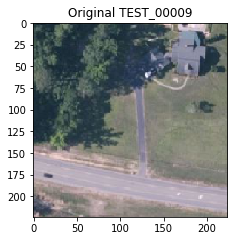

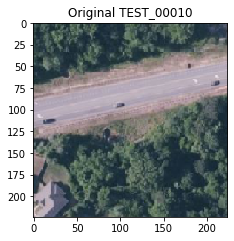

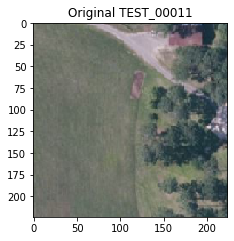

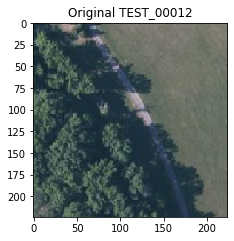

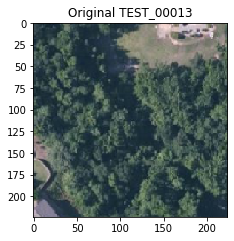

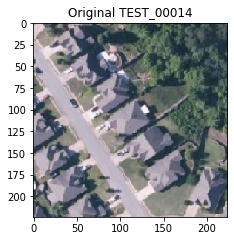

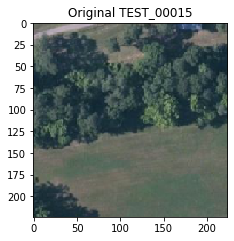

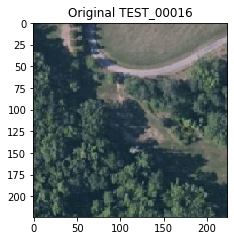

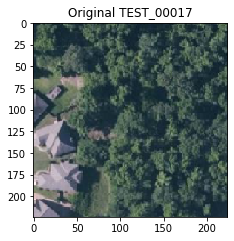

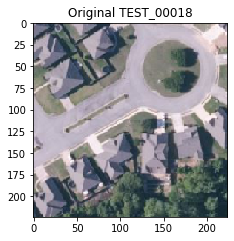

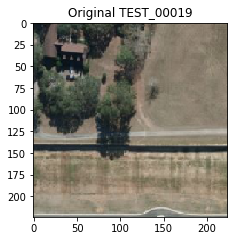

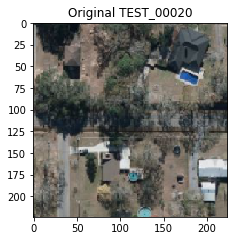

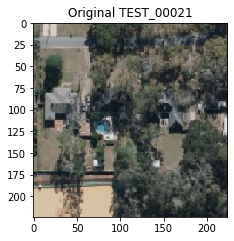

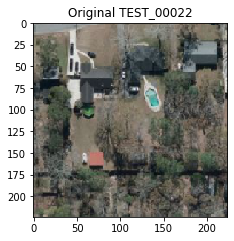

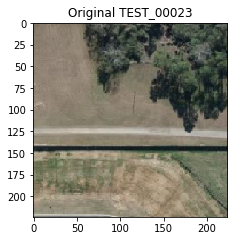

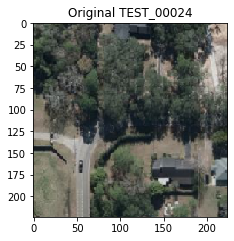

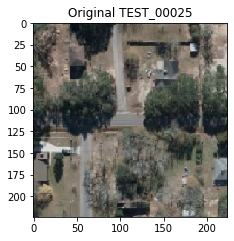

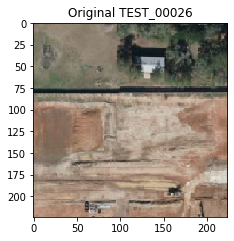

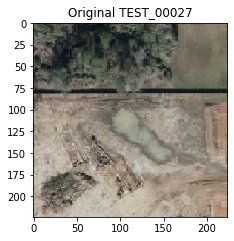

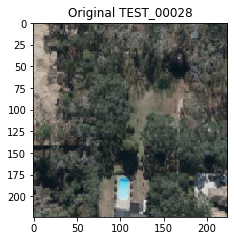

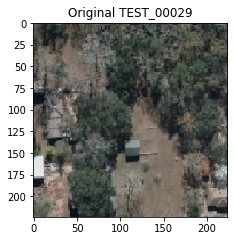

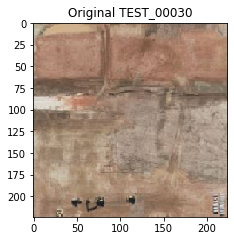

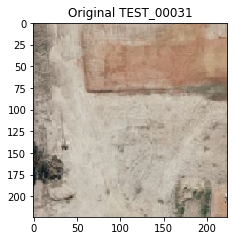

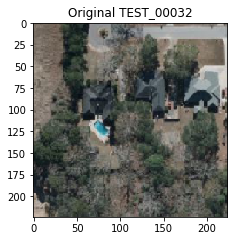

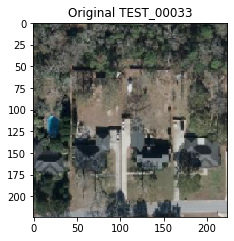

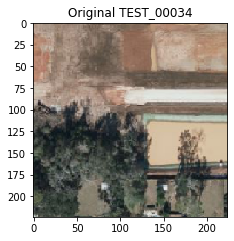

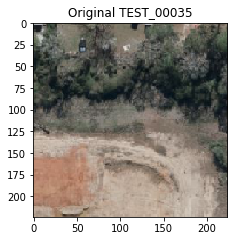

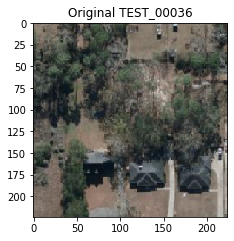

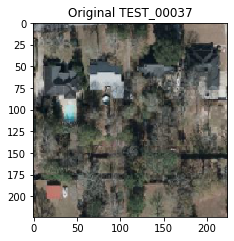

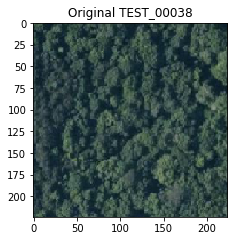

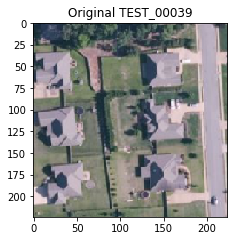

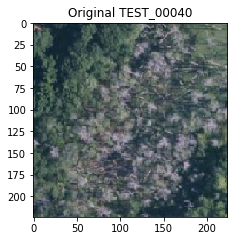

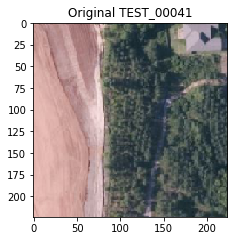

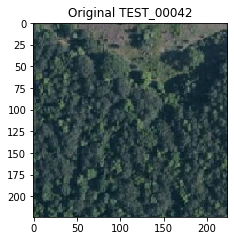

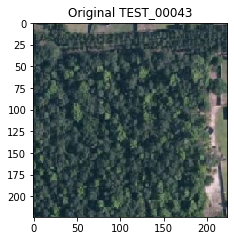

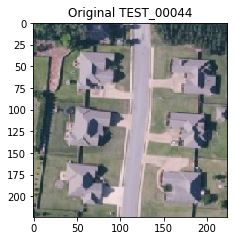

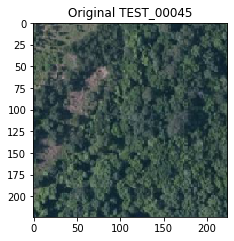

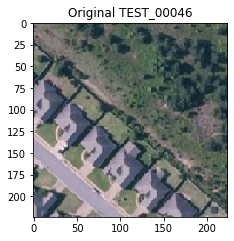

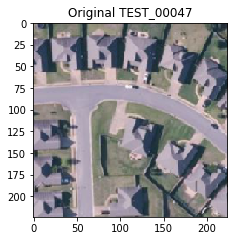

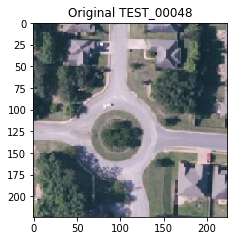

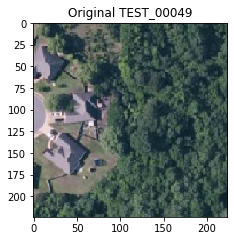

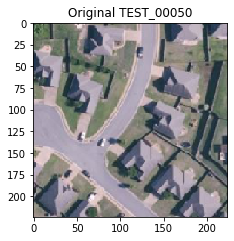

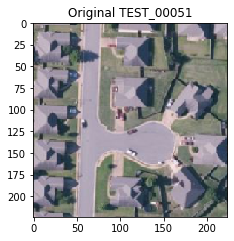

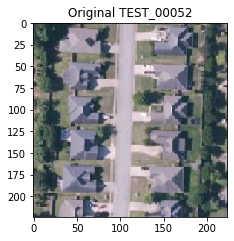

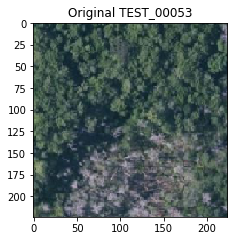

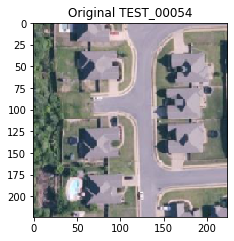

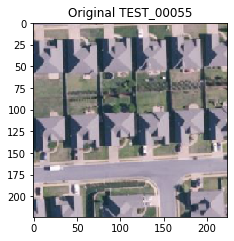

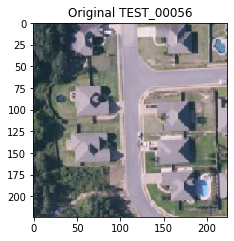

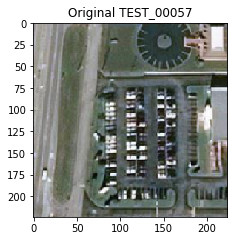

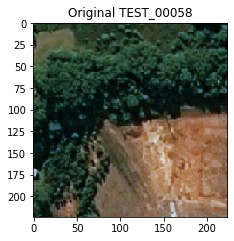

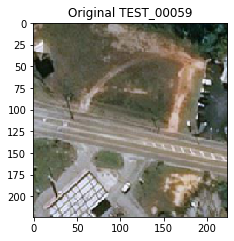

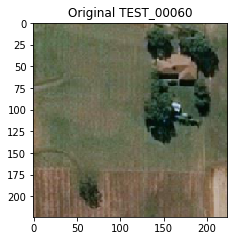

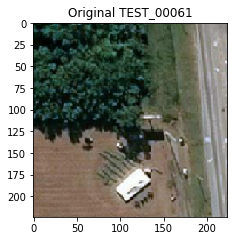

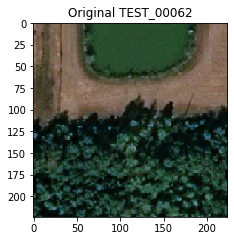

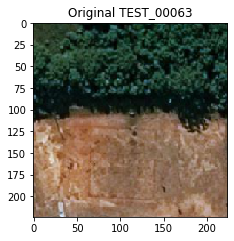

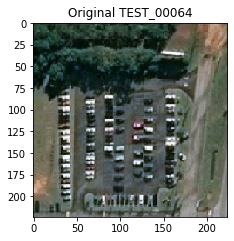

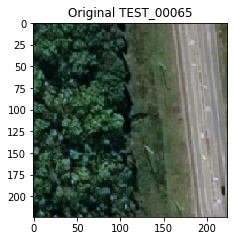

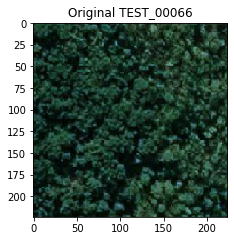

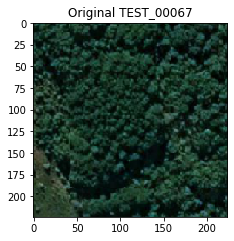

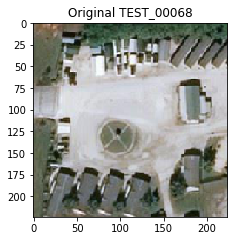

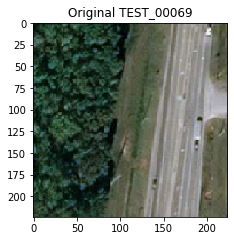

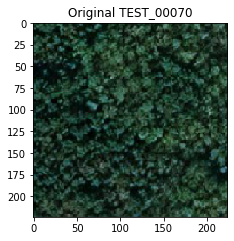

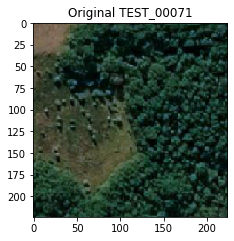

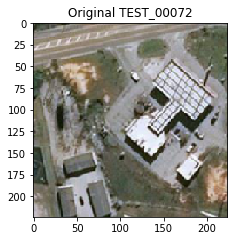

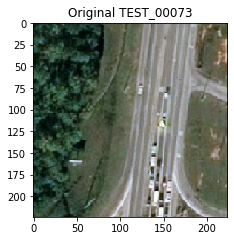

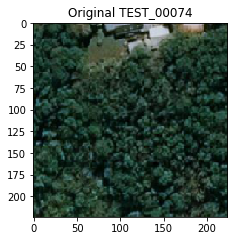

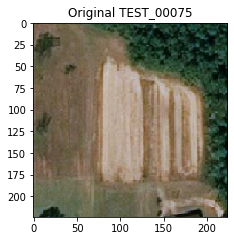

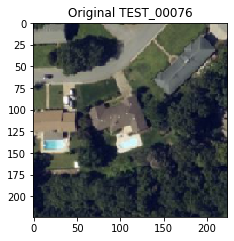

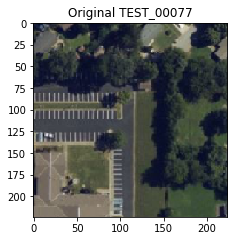

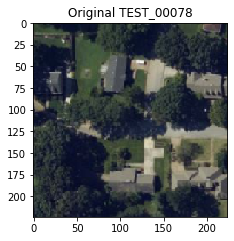

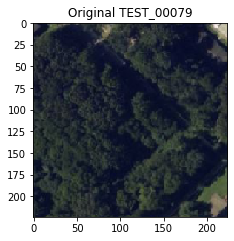

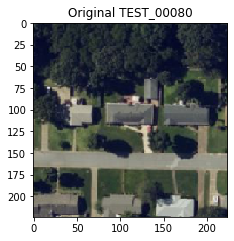

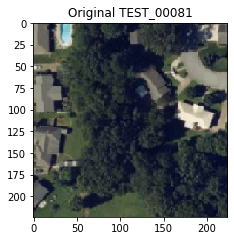

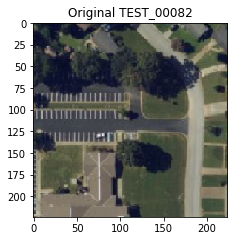

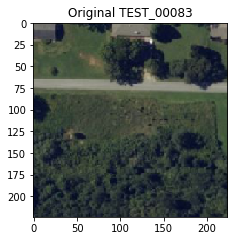

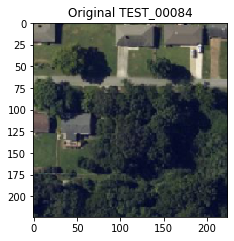

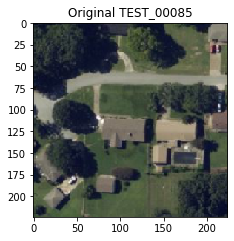

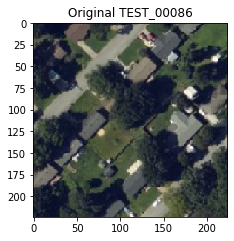

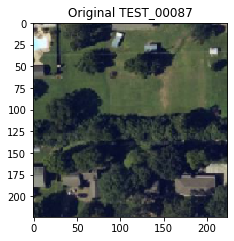

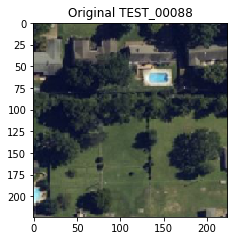

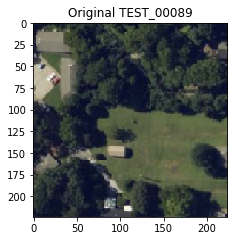

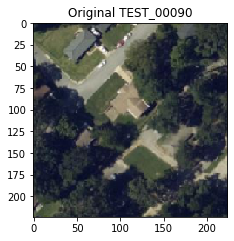

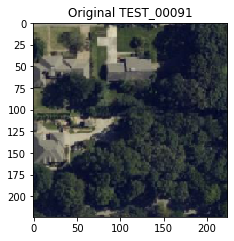

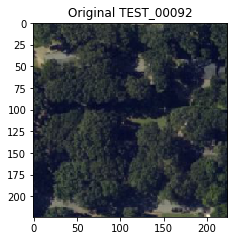

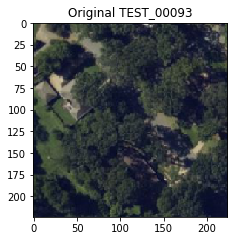

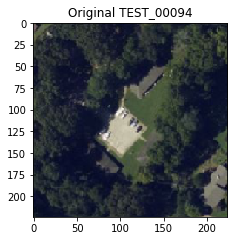

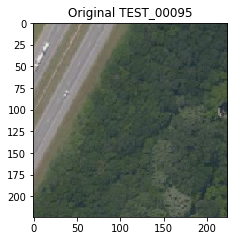

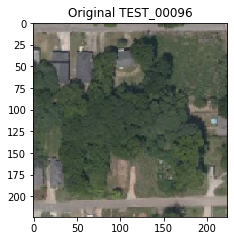

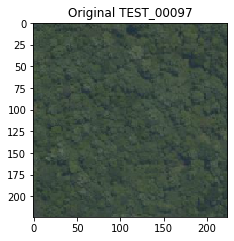

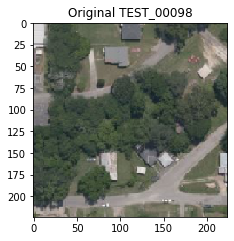

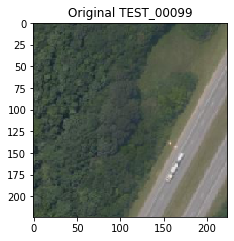

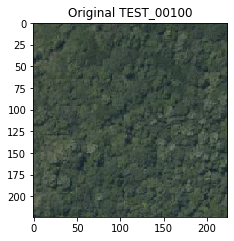

In [13]:
submit_csv1 = ''     
submit_csv2 = ''
submit_csv3 = ''

def visual(image_idx, submit_csv1, submit_csv2, submit_csv3):
    df = pd.read_csv('sample_submission.csv', header=None)
    image_names = df[0].values
    image_name = image_names[image_idx + 1] 
    image = cv2.imread('./test_img/' + image_name + '.png')
# Decoding - submit_csv1  
    if submit_csv1 != '':
        # CSV 파일 읽기
        df = pd.read_csv(submit_csv1, header=None)

        # 이미지 파일 이름과 마스크 정보 파싱
        image_names = df[0].values
        mask_info = df[1].values

        image_name = image_names[image_idx + 1]
        mask_str = mask_info[image_idx + 1]
        print(image_names[image_idx + 1])

        # 이미지 파일과 마스크 정보 출력
        image = cv2.imread('./test_img/' + image_name + '.png')
        mask_decoded1 = rle_decode(mask_str, shape=(224, 224))
    
# Decoding - submit_csv2 
    if submit_csv2 != '':
        # CSV 파일 읽기
        df = pd.read_csv(submit_csv2, header=None)

        # 이미지 파일 이름과 마스크 정보 파싱
        image_names = df[0].values
        mask_info = df[1].values

        image_name = image_names[image_idx + 1]
        mask_str = mask_info[image_idx + 1]

        # 이미지 파일과 마스크 정보 출력
        image = cv2.imread('./test_img/' + image_name + '.png')
        mask_decoded2 = rle_decode(mask_str, shape=(224, 224))
        
# Decoding - submit_csv3   
    if submit_csv3 != '':
        # CSV 파일 읽기
        df = pd.read_csv(submit_csv3, header=None)

        # 이미지 파일 이름과 마스크 정보 파싱
        image_names = df[0].values
        mask_info = df[1].values

        image_name = image_names[image_idx + 1]
        mask_str = mask_info[image_idx + 1]

        # 이미지 파일과 마스크 정보 출력
        image = cv2.imread('./test_img/' + image_name + '.png')
        mask_decoded3 = rle_decode(mask_str, shape=(224, 224))

# 시각화 - original image
    plt.figure(figsize=(16, 8))
    plt.subplot(1, 4, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('Original ' + image_name)
    
# 시각화 - submit_csv1
    if submit_csv1 != '':
        # 디코딩된 값을 이미지 위에 표시
        plt.subplot(1, 4, 2)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.imshow(mask_decoded1, cmap='jet', alpha=0.7)  # alpha 값을 조정하여 투명도 조절
        plt.title(submit_csv1)
    
# 시각화 - submit_csv2
    if submit_csv2 != '':
        # 디코딩된 값을 이미지 위에 표시
        plt.subplot(1, 4, 3)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.imshow(mask_decoded2, cmap='jet', alpha=0.7)  # alpha 값을 조정하여 투명도 조절
        plt.title(submit_csv2)
        
# 시각화 - submit_csv3
    if submit_csv3 != '':
        # 디코딩된 값을 이미지 위에 표시
        plt.subplot(1, 4, 4)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.imshow(mask_decoded3, cmap='jet', alpha=0.7)  # alpha 값을 조정하여 투명도 조절
        plt.title(submit_csv3)
              
    plt.show()
    
    

submit_csv1 #= 'submit(DeepUNet 0.3 5).csv'
submit_csv2 #= 'submit(DeepUNet 0.4 5).csv'
submit_csv3 #= 'submit(DeepUNet 0.5 5).csv'
        
for i in range(0, 101):
    visual(i, submit_csv1, submit_csv2, submit_csv3)